In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('reviews.csv')
df.head()

,itemId,category,name,rating,originalRating,reviewTitle,reviewContent,likeCount,upVotes,downVotes,helpful,relevanceScore,boughtDate,clientType,retrievedDate
0,100002528,beli-harddisk-eksternal,Kamal U.,5,NaN,NaN,bagus mantap dah sesui pesanan,0,0,0,True,26.51,09 Apr 2019,androidApp,2019-10-02
1,100002528,beli-harddisk-eksternal,yofanca m.,4,NaN,NaN,"Bagus, sesuai foto",0,0,0,True,22.49,24 Sep 2017,androidApp,2019-10-02
2,100002528,beli-harddisk-eksternal,Lazada Customer,5,NaN,ok mantaaapppp barang sesuai pesanan.. good,okkkkk mantaaaaaaapppp ... goood,0,0,0,True,21.50,04 Apr 2018,androidApp,2019-10-02
3,100002528,beli-harddisk-eksternal,Lazada Customer,4,NaN,NaN,bagus sesuai,0,0,0,True,20.51,22 Sep 2017,androidApp,2019-10-02
4,100002528,beli-harddisk-eksternal,Yosep M.,5,NaN,NaN,NaN,0,0,0,True,16.01,17 Agu 2018,androidApp,2019-10-02


In [3]:
df = df[['rating', 'reviewTitle', 'reviewContent']]
df = df.dropna(subset=['rating'])
df = df.dropna(subset=['reviewTitle', 'reviewContent'], how='all')
df.head()

,rating,reviewTitle,reviewContent
0,5,NaN,bagus mantap dah sesui pesanan
1,4,NaN,"Bagus, sesuai foto"
2,5,ok mantaaapppp barang sesuai pesanan.. good,okkkkk mantaaaaaaapppp ... goood
3,4,NaN,bagus sesuai
7,1,ada pengirimn ntb bima,bima


In [4]:
df['review'] = df['reviewTitle'] + ' ' + df['reviewContent']
df.loc[df['reviewTitle'].astype(str) == 'nan', 'review'] = df['reviewContent']
df.loc[df['reviewContent'].astype(str) == 'nan', 'review'] = df['reviewTitle']

df = df.drop(['reviewTitle', 'reviewContent'], axis=1)
df.head()

,rating,review
0,5,bagus mantap dah sesui pesanan
1,4,"Bagus, sesuai foto"
2,5,ok mantaaapppp barang sesuai pesanan.. good ok...
3,4,bagus sesuai
7,1,ada pengirimn ntb bima bima


In [5]:
import nltk
import string
from Sastrawi.Stemmer import StemmerFactory

stop_words = set(nltk.corpus.stopwords.words('indonesian'))
stemmer = StemmerFactory.StemmerFactory().create_stemmer()

def rm_dupes(s):
    prev = ''
    new = ''
    for i in s:
        if i != prev:
            prev = i
            new += i
    return new

def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation + '0123456789'))
    text = rm_dupes(text)
    text = stemmer.stem(text)
    text = nltk.word_tokenize(text)
    text = [i for i in text if i not in stop_words]
    text = list(set(text))
    text = ' '.join(text)
    return text

def clean_rating(x):
    if x >= 3:
        return 1
    return 0

df['rating'] = df['rating'].apply(clean_rating)
df['review'] = df['review'].apply(clean_text)
df.head()

,rating,review
0,1,bagus dah sesui mantap pesan
1,1,sesuai foto bagus
2,1,sesuai god mantap ok barang pesan
3,1,sesuai bagus
7,0,bima ntb pengirimn


In [6]:
print('Rows: %d' %(len(df)))

cnt = [0, 0]
for i, j in df.iterrows():
   cnt[j['rating']] += 1

print('Negative: %d\nPositive: %d' %(cnt[0], cnt[1]))

Rows: 109355
Negative: 9451
Positive: 99904


In [7]:
df_n = df[df['rating'] == 0][:9000]
df_p = df[df['rating'] == 1][:9000]

df = pd.concat([df_n, df_p])

print('Rows: %d' %(len(df)))

cnt = [0, 0]
for i, j in df.iterrows():
   cnt[j['rating']] += 1

print('Negative: %d\nPositive: %d' %(cnt[0], cnt[1]))

Rows: 18000
Negative: 9000
Positive: 9000


In [8]:
words = set()
for i, j in df.iterrows():
    for k in j['review']:
        words.add(k)

print('Number of words: %d' %(len(words)))

Number of words: 27


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

data = []
for i, j in df.iterrows():
    data.append([j['review'] + ',' + str(j['rating'])])

vectorizer = TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False)
x_data = vectorizer.fit_transform(data)

In [10]:
y_data = df['rating']

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

In [12]:
from sklearn.naive_bayes import BernoulliNB

model = BernoulliNB()
model.fit(x_train, y_train)
print('Accuracy on train data: %.2f%%' %(100 * model.score(x_train, y_train)))

Accuracy on train data: 100.00%


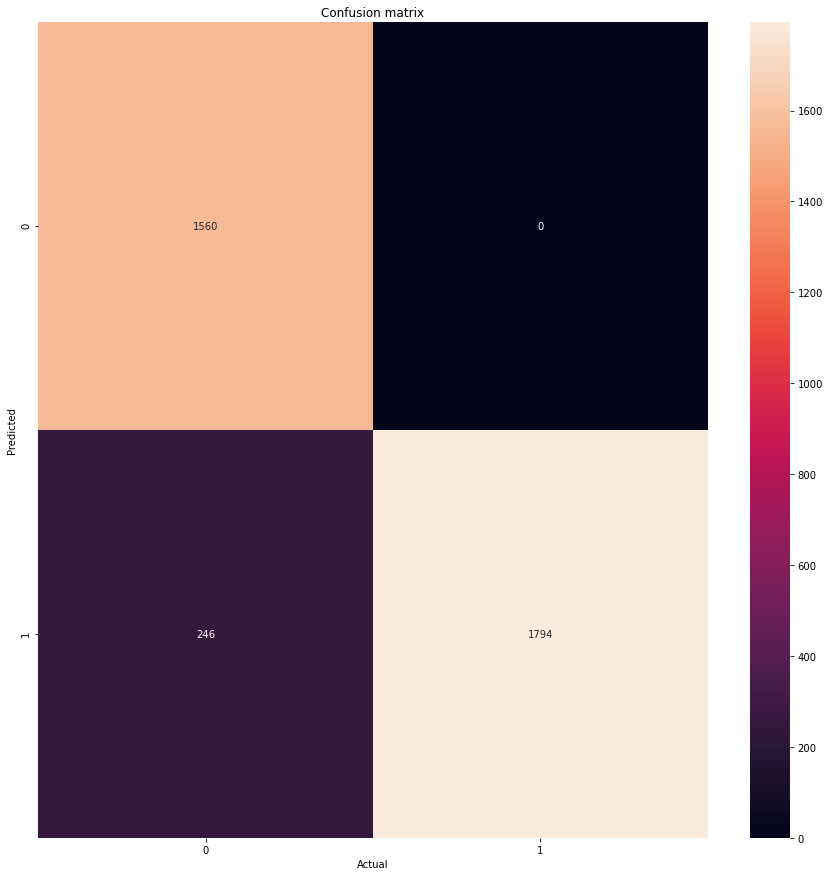

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = [i for i in model.predict(x_test)]
matrix = confusion_matrix(y_pred, y_test)

plt.figure(figsize=(15, 15))
plot = plt.subplot()
sns.heatmap(matrix, annot=True, ax=plot, fmt='g')

plot.set_title('Confusion matrix')
plot.set_xlabel('Actual')
plot.set_ylabel('Predicted')
plt.show()

In [14]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

print('Precision:', precision_score(y_pred, y_test, average='weighted'))
print('Recall:', recall_score(y_pred, y_test, average='weighted'))
print('F1:', f1_score(y_pred, y_test, average='weighted'))
print('Accuracy:', accuracy_score(y_pred, y_test))

Precision: 0.9409745293466224
Recall: 0.9316666666666666
F1: 0.9319714683426366
Accuracy: 0.9316666666666666
